# Анализ взаимодействия с клиентами на основе данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
проанализировать основные признаки, наиболее сильно влияющие на отток;
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

#pip install numpy scipy scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage


In [2]:
try:
    df= pd.read_csv('D:\IT\courses Python\yandex_practicum\\11_ML project\gym_churn.csv')
except:
    df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных (EDA)

In [3]:
# Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения
df.info()

#Приведем столбцы к нижнему регистру
df.columns = df.columns.str.lower()

display(df.describe().T)
print('Количество дубликатов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Количество дубликатов: 0


- Пропусков и дубликатов нет.
- Тип данных числовые, категориальных нет.
- Названия столбцов приведены к нижнему регистру.
- По среднему значению можно сказать, что:
    - среднее распределение пола
    - 85% пользователей живут рядом
    - почти 50% пришли от партнера-клуба
    - по промо-акции привели друга 30%
    - почти все оставляют телефон
    - абоненты в среднем около 5 месяцев
    - lifetime= 3.7
    - средняя частота посещений в неделю за все время с начала действия абонемента около 2
    - средняя частота посещений в неделю за предыдущий месяц 1.8
    - факт оттока в текущем месяце 26.5%

In [4]:
#Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df_churn = df.groupby('churn').mean()
df_churn.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Те кто ушел в отток:
- на 36% только являются партнерами клуба
- 18% пришли по акции приведи друга
- имеют маленький период абонента 1-2 месяца

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


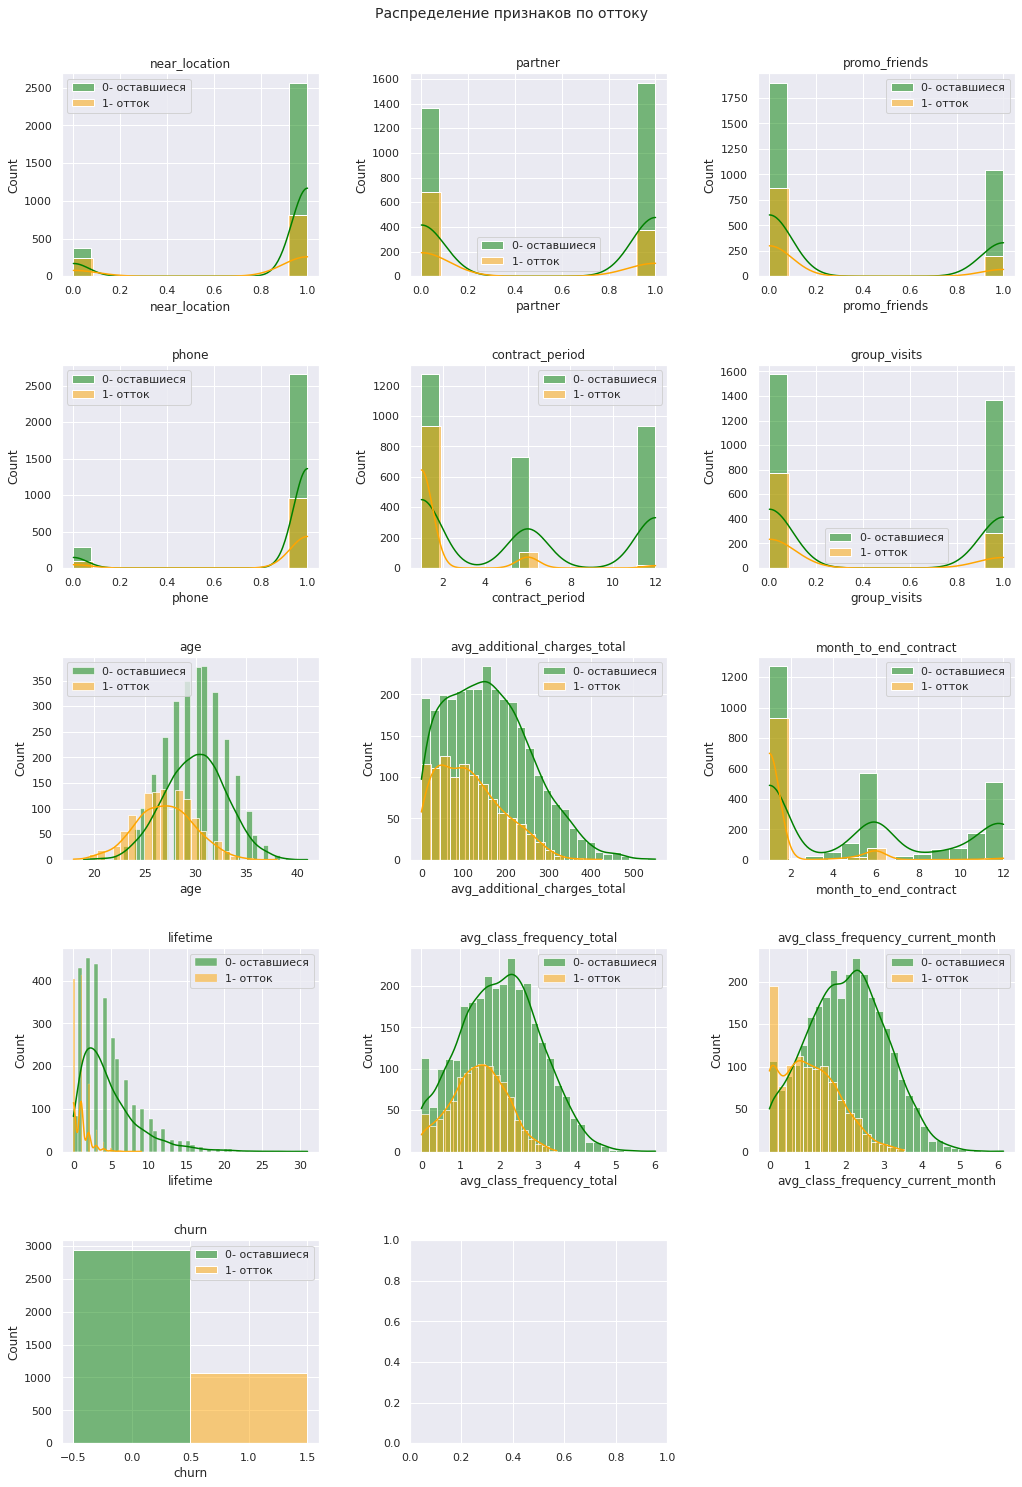

In [5]:
#Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
column, row = 3,6
plt.figure(figsize = (15,25))
for i, j in enumerate(df):
    for churn in df['churn'].unique():
        data = df.query('churn == @churn')
        if churn == 1:
            sns.histplot(data[j], color = 'orange', kde=True, label='1- отток')
        if churn == 0:
            sns.histplot(data[j], color = 'green', kde=True, label='0- оставшиеся')
    plt.title(j)
    plt.legend()
    plt.subplot(row, column, i+1)
plt.suptitle('Распределение признаков по оттоку', fontsize=14)
plt.tight_layout(pad=3.0)    
plt.show() 

По графикам видно, что распределение признаков по оттокам соответствует средним значениям. По количеству данных, в группе 0- оставшихся людей почти в 3 раза больше, чем у 1- оттока.

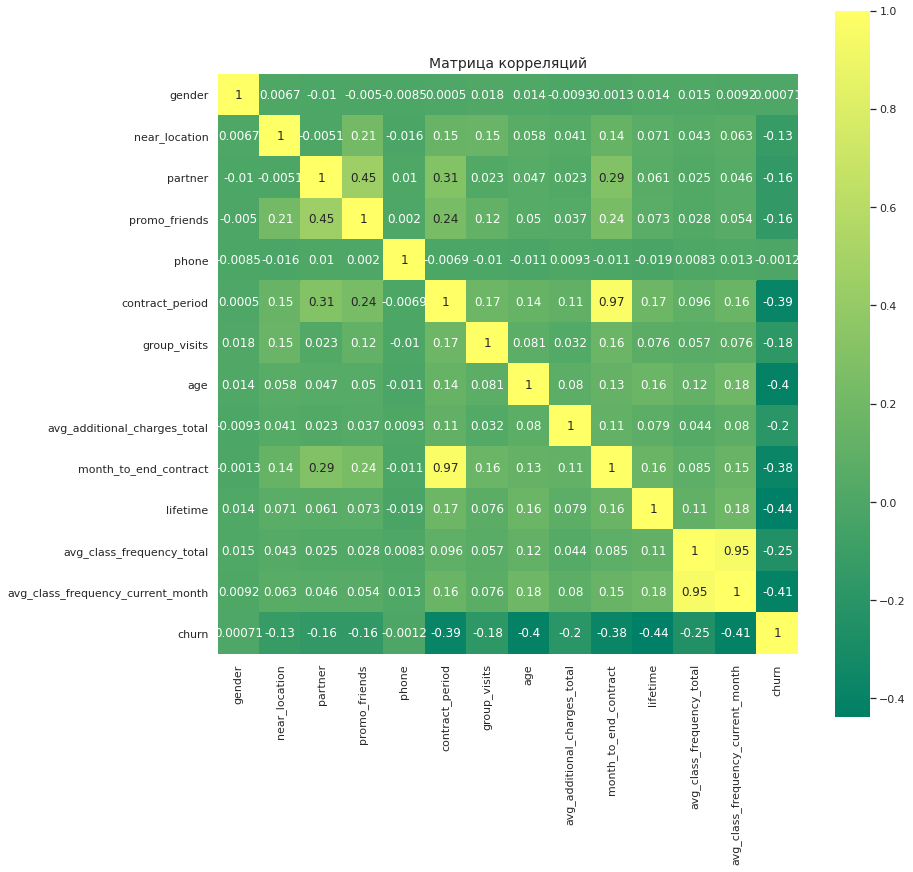

In [6]:
#Постройте матрицу корреляций и отобразите её.
plt.figure(figsize=(13,13))
sns.heatmap(data = df.corr(), annot=True, square=True, cmap='summer')
plt.title('Матрица корреляций', fontsize=14)
plt.show()

- по матрице коррелиции сильную зависимость наблюдаем только у 'contract_period' - 'month_to_end_contract' и 'avg_class_frequency_total' - 'avg_class_frequency_current_month'. Во избежание мультиколлинеарности, удалим из датафрейма один из них- 'month_to_end_contract' и 'avg_class_frequency_current_month'.

In [7]:
df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1, inplace=True)
df.head(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0


## Постройте модель прогнозирования оттока клиентов
Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [8]:
#целевая переменнная
y = df['churn'] 
#признаки
X = df.drop('churn', axis=1)  
print('Размер датасета:', df.shape)
#Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
#Для равномерного распределения данных зададим параметр стратификации
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# определим функцию, которая будет выводить наши метрики
def all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tДоля правильных ответов- Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tТочность- Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tПолнота- Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tПлощадь под кривой- ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
model_lr = LogisticRegression(random_state=0)
# обучим модель
model_lr.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_lr = model_lr.predict(X_test_st)
probabilities_lr = model_lr.predict_proba(X_test_st)[:, 1]
# выведем все метрики
all_metrics(
    y_test,
    predictions_lr,
    probabilities_lr,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)  
# обучим модель случайного леса
model_rf.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_rf = model_rf.predict(X_test_st) 
probabilities_rf = model_rf.predict_proba(X_test_st)[:,1]
# выведем все метрики
all_metrics(
    y_test,
    predictions_rf,
    probabilities_rf,
    title='Метрики для модели случайного леса:'
)

Размер датасета: (4000, 12)
Метрики для модели логистической регрессии:
	Доля правильных ответов- Accuracy: 0.91
	Точность- Precision: 0.83
	Полнота- Recall: 0.83
	Площадь под кривой- ROC_AUC: 0.96
Метрики для модели случайного леса:
	Доля правильных ответов- Accuracy: 0.89
	Точность- Precision: 0.81
	Полнота- Recall: 0.79
	Площадь под кривой- ROC_AUC: 0.95


- По выбранным метрикам видно качество моделей. Логистическая регрессия показала себя лучше случайного леса. Для дополнительной оценки качества классификатора добавила метрику площадь под кривой roc_auc.

## Сделайте кластеризацию клиентов

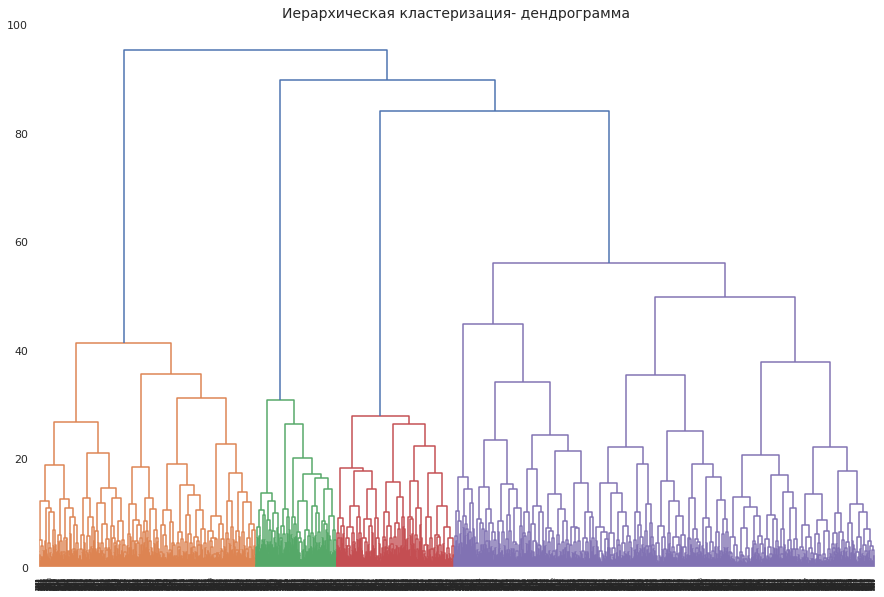

In [9]:
#Стандартизируйте данные.
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация- дендрограмма', fontsize=14)
plt.show()

- На дендрограмме 4 кластера. Но можно выделить 5 кластеров, разбив один большой. 

In [10]:
#Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов (число кластеров n=5)
#Стандартизация
sc = StandardScaler()
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

#Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
df['cluster_km'] = labels
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Выводы по кластерам.

Общее у всех кластеров:
- гендерное деление пополам
- средний возраст 29 лет
- суммарная выручка от других услуг фитнес-центра 138-156 у.е.
- время с момента первого обращения в фитнес-центр (lifetime) -3-4 месяца
- средняя частота посещений в неделю за все время с начала действия абонемента около 2 раз.

По кластеру 0:
- посетители фитнес клуба живут или работают ДАЛЕКО,
- 49% являются сотрудниками партнеров клуба
- 8% пришли по акции "приведи друга"
- оставляют телефон
- длительность текущего действующего абонемента - 3 месяца
- посещение групповых занятий - 23.5%
- факт ОТТОКА в текущем месяце- 40%

По кластеру 1:
- посетители фитнес клуба живут или работают РЯДОМ,
- 95.5% являются сотрудниками партнеров клуба
- 89% пришли по акции "приведи друга"
- оставляют телефон
- длительность текущего действующего абонемента - 8 месяцев
- посещение групповых занятий - 46%
- факт ОТТОКА в текущем месяце- 12%

По кластеру 2:
- посетители фитнес клуба живут или работают РЯДОМ,
- 24% являются сотрудниками партнеров клуба
- 6% пришли по акции "приведи друга"
- оставляют телефон
- длительность текущего действующего абонемента - 3 месяца
- НЕТ посещений групповых занятий
- факт ОТТОКА в текущем месяце- 38%

По кластеру 3:
- посетители фитнес клуба живут или работают РЯДОМ,
- 25% являются сотрудниками партнеров клуба
- 8% пришли по акции "приведи друга"
- оставляют телефон
- длительность текущего действующего абонемента - 4.5 месяца
- посещение групповых занятий - 100%
- факт ОТТОКА в текущем месяце- 20%

По кластеру 4:
- посетители фитнес клуба живут или работают рядом 86%,
- 47% являются сотрудниками партнеров клуба
- 30.5% пришли по акции "приведи друга"
- БЕЗ телефона
- длительность текущего действующего абонемента - 5 месяца
- посещение групповых занятий - 43%
- факт ОТТОКА в текущем месяце- 27%

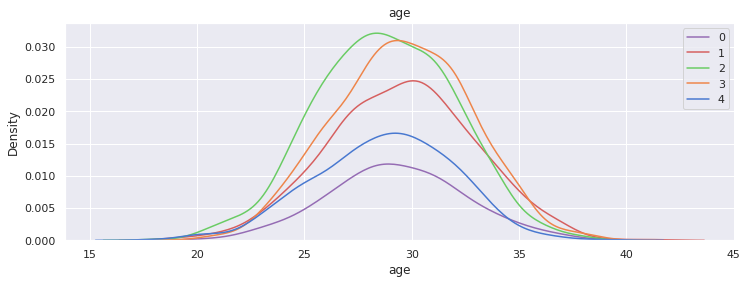

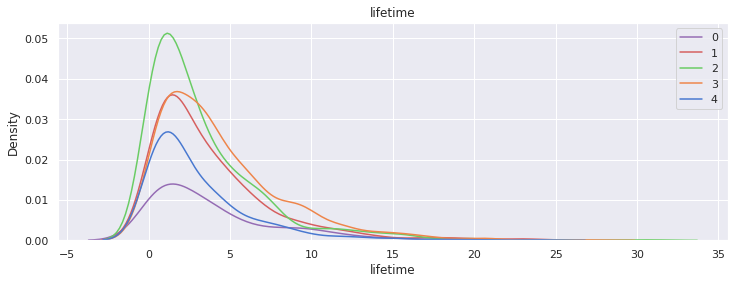

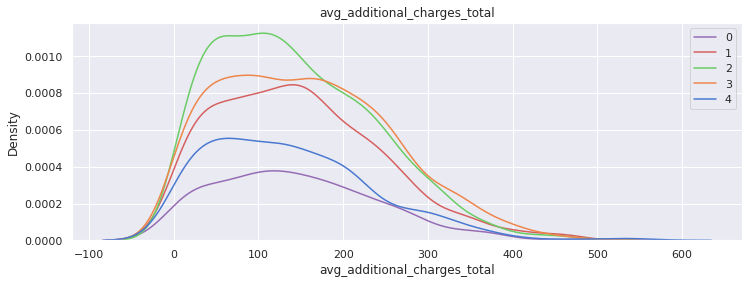

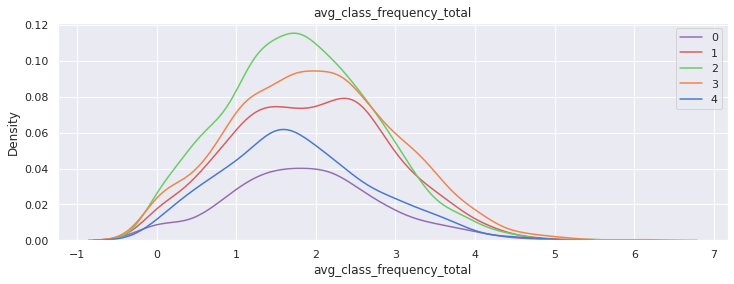

In [11]:
#Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним? 
# Разделим на две группы категориальные и числовые признаки.
categorical_columns = ['age', 'lifetime', 'avg_additional_charges_total', 'avg_class_frequency_total']

for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.kdeplot(x=df[column], hue="cluster_km", data=df, palette='muted')
    plt.title(column)
    plt.legend(['0','1', '2', '3', '4', '5'])
    plt.show()

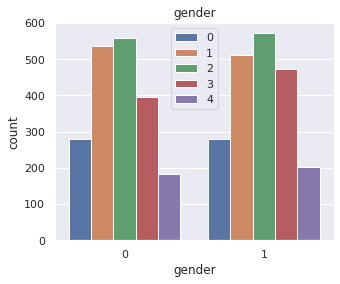

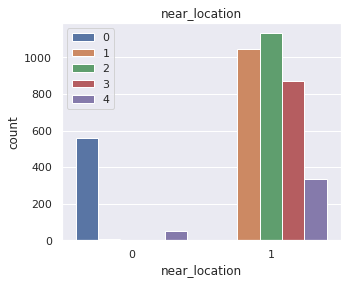

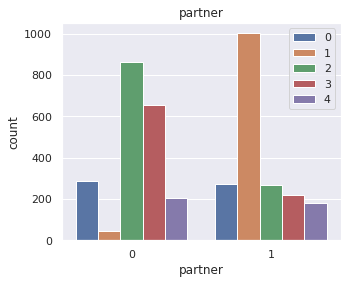

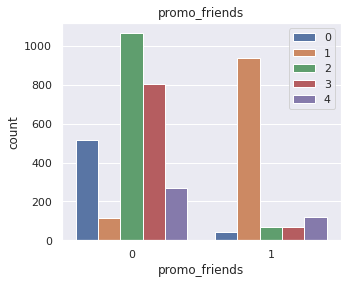

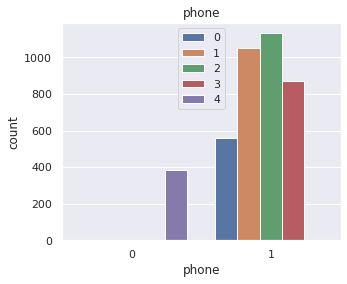

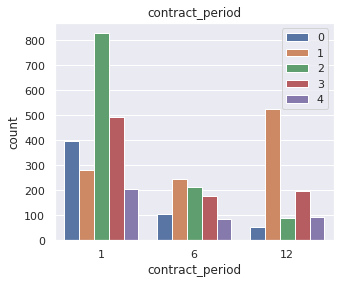

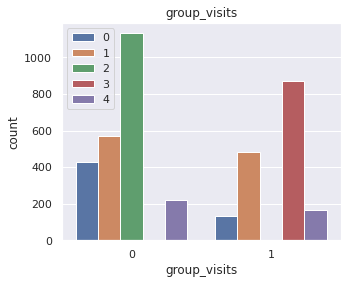

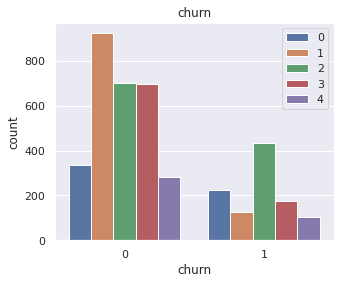

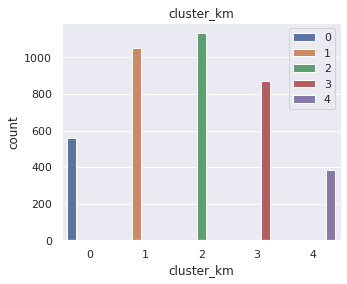

In [12]:
for column in df.columns:
    if column not in categorical_columns:
        plt.figure(figsize=(5, 4))
        sns.countplot(x=df[column], hue="cluster_km", data=df) 
        plt.title(column)
        plt.legend()
     
plt.show()

По графикам распеределения признаков:
- gender - распределение равномерное
- near_location - 0 кластер= 0
- partner, promo_friends - 1 кластер имеет максимальные данные= 1. 2 и 3 кластеры лидируют= 0
- phone - 4 кластер=0
- contract_period - 1 месяц= 2 кластер лидирует, 6 месяцев= равномерное распределение, 12 месяцев- 1 кластер лидирует
- group_visits - 2 кластер=0 в лидерах. 3 кластер=1
- churn - 1 кластер=0 максимальный уровень, на втором месте 2 и 3 кластеры=0. 2 кластер=1 больше всего значений

In [13]:
#Для каждого полученного кластера посчитайте долю оттока (методом groupby()). 
# Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?
df_churn_part= df.groupby('cluster_km')['churn'].count() / df['churn'].count()
df_churn_part.sort_values()

cluster_km
4    0.09650
0    0.14025
3    0.21775
1    0.26250
2    0.28300
Name: churn, dtype: float64

Доли оттока у кластеров:
- самая минимальная у 4 кластера составляет 9.7%, 
- 0 кластер- 14%, 
- 3 кластер- 21.8%, 
- 1 кластер- 26.2% 
- максимальная у 2 кластера - 28.3%.

## Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

## Основные выводы 
1) Проведена предобработка и анализ средних показателей датафрейма. По матрице корреляции убрали мультиколлинеарность в данных.

2) Построили две модели прогнозирования оттока клиентов двумя способами: логистической регрессией и случайным лесом. Определили качество моделей по метрикам accuracy, precision, recall и roc_auc.

3) Сделали кластеризацию клиентов. Отрисовали дендрограмму- определили количество кластеров и на основании алгоритма K-Means и спрогнозировали кластеры клиентов. 
    - По средним значениям, распределению признаков и долям обнаружили, что самая минимальная доля оттока у кластера 0 составляет 9.7%, потом 1 кластер- 12%, 3 кластер- 16.5%, 4 кластер- 21% и максимальная у 2 кластера - 40.7%.
4) Разделили на две группы клиентов.

- Группа кластера 2 имеет 38% оттока и самый не надежный. 
    Людям этой группы характерно:
    - 24% являются сотрудниками партнеров клуба
    - 6% пришли по акции "приведи друга"
    - длительность текущего действующего абонемента - 3 месяца
    - НЕТ посещений групповых занятий
    
- Группа кластера 1 имеет 12% оттока. 
    Людям этой группы характерно:
    - посетители фитнес клуба живут или работают РЯДОМ,
    - 95.5% являются сотрудниками партнеров клуба
    - 89% пришли по акции "приведи друга"
    - длительность текущего действующего абонемента - 8 месяцев
    - посещение групповых занятий - 46%

### Рекомендации для стратегии взаимодействия с клиентами и их удержания.
1) Больше предлагать длительных абонементов на год. 

2) Больше вовлекать в групповые занятия.

3) Привлекать акцией приведи друга

4) Увеличивать количество партнеров клуба.

5) Ориентироваться на людей, которые живут или работают рядом в возрасте от 25- 35 лет.